# Install libraries

In [ ]:
%pip install scikit-learn
%pip install matplotlib
%pip install pandas
%pip install numpy
%pip install lightgbm

# Load the dataset

In [581]:
import pandas as pd

# Load the dataset
heart_failure_df = pd.read_csv('data/heart.csv')

feature_names = heart_failure_df.columns[:-1]
target_col_name = 'HeartDisease'
cat_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']
num_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

assert len(feature_names) == len(cat_features) + len(num_features) # sanity check

heart_failure_df.head() # display the first few rows of the dataframe

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [582]:
# Check data types
heart_failure_df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [583]:
# FastingBS is a categorical feature, but it is encoded as an integer. We need to convert it to a boolean.
heart_failure_df['FastingBS'] = (heart_failure_df['FastingBS'] == 1).astype(bool)
heart_failure_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,False,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,False,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,False,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,False,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,False,Normal,122,N,0.0,Up,0


In [584]:
# Check for missing values
missing_values = heart_failure_df.isnull().sum()
print(missing_values)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


# Simple processing and run

### Encoding

In [585]:
from sklearn.preprocessing import LabelEncoder # Encode categorical features

label_encoder = LabelEncoder()

def encode_categorical_features(df):
    for col in df.columns:
        if df[col].dtype == 'object' or df[col].dtype == 'bool' or df[col].dtype == 'category':
            df[col] = label_encoder.fit_transform(df[col])

X = heart_failure_df.drop(target_col_name, axis=1)
y = heart_failure_df[target_col_name]

encode_categorical_features(X)

X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,1,1,140,289,0,1,172,0,0.0,2
1,49,0,2,160,180,0,1,156,0,1.0,1
2,37,1,1,130,283,0,2,98,0,0.0,2
3,48,0,0,138,214,0,1,108,1,1.5,1
4,54,1,2,150,195,0,1,122,0,0.0,2


In [586]:
from sklearn.model_selection import train_test_split # Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Helper functions

In [587]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import lightgbm as lgb

# Plot confusion matrix with annotations
def plot_confusion_matrix(cm, classes=['Negative', 'Positive'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        pass
        # print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def random_forest_classifier(X_train, y_train, X_test, y_test, n_estimators=100, class_weight=None):
    # Train a random forest classifier
    clf = RandomForestClassifier(n_estimators=n_estimators, class_weight=class_weight)
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    print(f'Training accuracy for RandomForest: {train_acc}')

    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    return cm, clf.feature_importances_


def lightgbm_classifier(X_train, y_train, X_test, y_test, n_estimators=100, class_weight=None):
    # Train a LightGBM classifier
    clf = lgb.LGBMClassifier(n_estimators=n_estimators, class_weight=class_weight, objective='binary', metric='binary_logloss', verbose=-1)
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    print(f'Training accuracy for LightGBM: {train_acc}')

    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    return cm, clf.booster_.feature_importance(importance_type='gain')


def print_feature_importances(feature_importances, feature_names=feature_names):
    # Feature importances
    indices = np.argsort(feature_importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(len(feature_names)):
        print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], feature_importances[indices[f]]))

### Random forest

Training accuracy for RandomForest: 1.0
Confusion matrix for RandomForest:
Feature ranking:
1. feature ST_Slope (0.217005)
2. feature Oldpeak (0.131313)
3. feature Cholesterol (0.108566)
4. feature MaxHR (0.106024)
5. feature ChestPainType (0.100131)
6. feature Age (0.095624)
7. feature ExerciseAngina (0.093909)
8. feature RestingBP (0.070263)
9. feature Sex (0.028323)
10. feature RestingECG (0.026567)
11. feature FastingBS (0.022274)


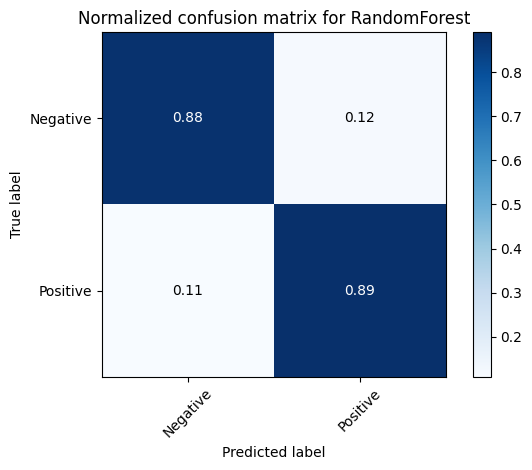

In [588]:
cm, feature_importances = random_forest_classifier(X_train, y_train, X_test, y_test, n_estimators=200)
print('Confusion matrix for RandomForest:')
plot_confusion_matrix(cm, normalize=True, title='Normalized confusion matrix for RandomForest')
print_feature_importances(feature_importances)

### LightGBM

Training accuracy for LightGBM: 1.0
Confusion matrix for LightGBM:
Feature ranking:
1. feature ST_Slope (1569.769219)
2. feature Oldpeak (618.256771)
3. feature MaxHR (464.613311)
4. feature Cholesterol (451.739179)
5. feature Age (396.068279)
6. feature ChestPainType (332.096914)
7. feature RestingBP (311.593737)
8. feature ExerciseAngina (209.947252)
9. feature Sex (149.538195)
10. feature FastingBS (67.996522)
11. feature RestingECG (66.286721)


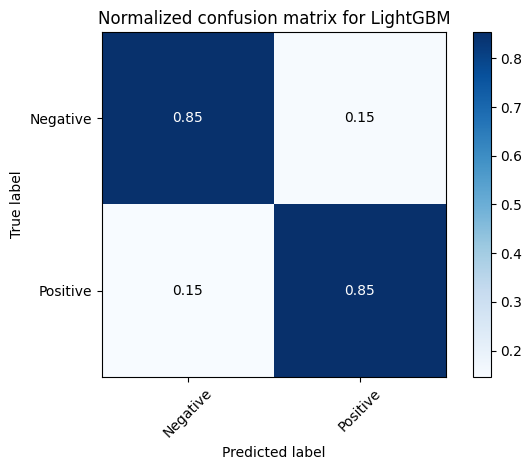

In [589]:
cm, feature_importances = lightgbm_classifier(X_train, y_train, X_test, y_test, n_estimators=200)
print('Confusion matrix for LightGBM:')
plot_confusion_matrix(cm, normalize=True, title='Normalized confusion matrix for LightGBM')
print_feature_importances(feature_importances)

##### False Negative is still very high, considered for a medical classication problem, this is where we want to focus on improving.
##### Both _RandomForst_ and _LightGBM_ agree on the top 2 most important features, by order: _ST\_Slope_, _Oldpeak_.

### Checking if imbalance in target

In [590]:
print(y.value_counts())

HeartDisease
1    508
0    410
Name: count, dtype: int64


##### Around 25% higher for Positive
##### This shouldn't be a concern, we should focus more the features.

# More features engineering

### Age

count    918.000000
mean      53.510893
std        9.432617
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: Age, dtype: float64


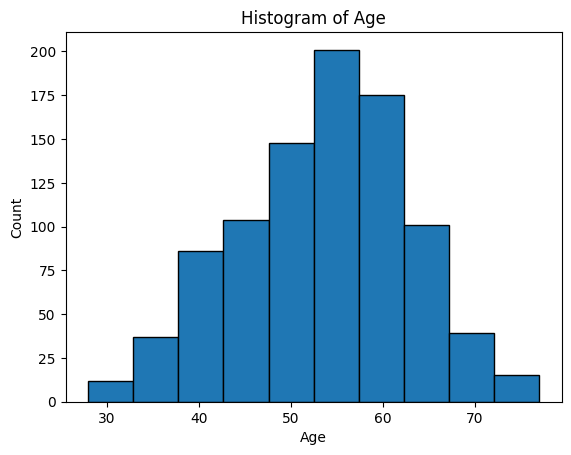

In [591]:
print(heart_failure_df['Age'].describe())

plt.hist(heart_failure_df['Age'], bins=10, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Age')
plt.show()

##### Lets change this to three ranges: min to 40, 41 to 60, above 60

In [592]:
heart_failure_df_feature_engineered = heart_failure_df.copy()

heart_failure_df_feature_engineered['Age'] = pd.cut(heart_failure_df['Age'], bins=[0, 40, 60, 100], labels=['0-40', '41-60', '61+'])
heart_failure_df_feature_engineered.head()

### MaxHR

count    918.000000
mean     136.809368
std       25.460334
min       60.000000
25%      120.000000
50%      138.000000
75%      156.000000
max      202.000000
Name: MaxHR, dtype: float64


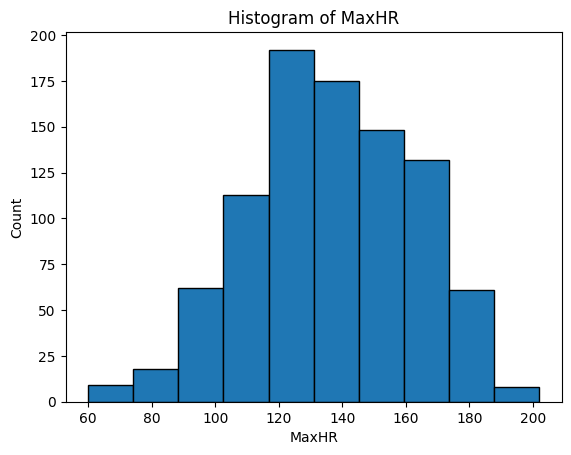

In [593]:
print(heart_failure_df['MaxHR'].describe())

plt.hist(heart_failure_df['MaxHR'], bins=10, edgecolor='black')
plt.xlabel('MaxHR')
plt.ylabel('Count')
plt.title('Histogram of MaxHR')
plt.show()

#### In Medical, normal max heart rate is derived from age

In [594]:
heart_failure_df_feature_engineered['max_hr_subtracted_by_age'] = heart_failure_df['MaxHR'] - heart_failure_df['Age']
heart_failure_df_feature_engineered.drop('MaxHR', axis=1, inplace=True)
heart_failure_df_feature_engineered.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,max_hr_subtracted_by_age
0,40,M,ATA,140,289,False,Normal,N,0.0,Up,0,132
1,49,F,NAP,160,180,False,Normal,N,1.0,Flat,1,107
2,37,M,ATA,130,283,False,ST,N,0.0,Up,0,61
3,48,F,ASY,138,214,False,Normal,Y,1.5,Flat,1,60
4,54,M,NAP,150,195,False,Normal,N,0.0,Up,0,68


In [595]:
X = heart_failure_df_feature_engineered.drop(target_col_name, axis=1)
encode_categorical_features(X)
y = heart_failure_df_feature_engineered[target_col_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Training accuracy for RandomForest: 1.0
Confusion matrix for RandomForest:
Feature ranking:
1. feature ST_Slope (0.231433)
2. feature Oldpeak (0.130051)
3. feature max_hr_subtracted_by_age (0.112060)
4. feature Cholesterol (0.104107)
5. feature ChestPainType (0.094439)
6. feature Age (0.091787)
7. feature ExerciseAngina (0.091180)
8. feature RestingBP (0.068738)
9. feature Sex (0.028866)
10. feature RestingECG (0.025145)
11. feature FastingBS (0.022195)


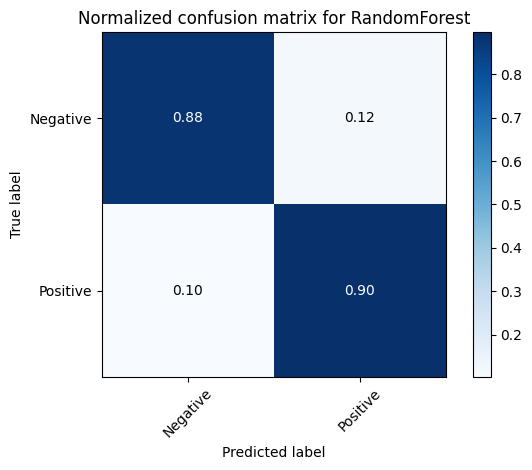

In [596]:
cm, feature_importances = random_forest_classifier(X_train, y_train, X_test, y_test, n_estimators=200)
print('Confusion matrix for RandomForest:')
plot_confusion_matrix(cm, normalize=True, title='Normalized confusion matrix for RandomForest')
print_feature_importances(feature_importances, feature_names=X.columns)

Training accuracy for LightGBM: 1.0
Confusion matrix for LightGBM:
Feature ranking:
1. feature ST_Slope (1579.430595)
2. feature Oldpeak (623.807601)
3. feature max_hr_subtracted_by_age (521.234972)
4. feature Cholesterol (429.275159)
5. feature Age (366.759729)
6. feature RestingBP (325.955034)
7. feature ChestPainType (309.048391)
8. feature ExerciseAngina (217.888451)
9. feature Sex (144.988917)
10. feature RestingECG (63.191195)
11. feature FastingBS (59.234458)


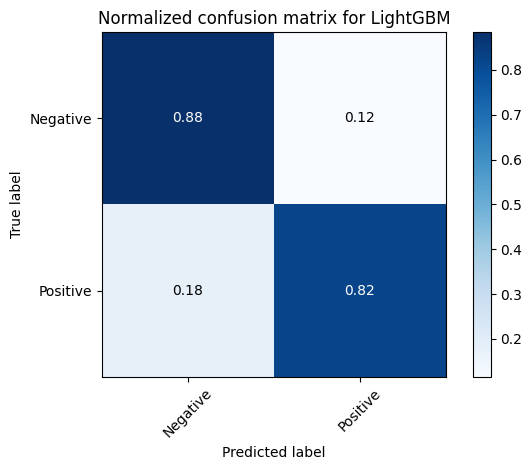

In [597]:
cm, feature_importances = lightgbm_classifier(X_train, y_train, X_test, y_test, n_estimators=200)
print('Confusion matrix for LightGBM:')
plot_confusion_matrix(cm, normalize=True, title='Normalized confusion matrix for LightGBM')
print_feature_importances(feature_importances, feature_names=X.columns)

##### We got much worse feature importance for Age, so this should be reverted. max_hr_subtracted_by_age has a small gain in importance, so lets keep this.

In [ ]:
heart_failure_df_feature_engineered['Age'] = heart_failure_df['Age']